*   **Run all code:** Go to **'Runtime'** top menu bar tab and select Run All or do the shortcut based on mac or windows.
*   Then open the last section of code: **'Open this code before running'** to provide the inputs.

#Import steps

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import BDay

#Functions:

In [2]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def sharpe_calc(returns, risk_free_rate=4.5):
    #Imputs return columns and gives the sharpe calculation
    excess_ret = returns.mean() - risk_free_rate/100/ 252
    sharpe_ratio = (excess_ret / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0
    return sharpe_ratio

def maxdraw_calc(cum_ret):
    roll_max = cum_ret.cummax()
    drawdown = cum_ret / roll_max - 1
    max_drawdown = drawdown.min()
    return max_drawdown

def cagr_calc(cum_ret, period=""):
    if period == "":
        period = len(cum_ret) / 252
    start_value = cum_ret.iloc[0]
    end_value = cum_ret.iloc[-1]
    cagr = (end_value / start_value) ** (1 / period) - 1
    return cagr


def parse_date(date_str, default):
    try:
        return datetime.strptime(date_str.strip(), '%m/%d/%y') if date_str else datetime.strptime(default, '%m/%d/%y')
    except ValueError:
        print("⚠️ Invalid format. Please use MM/DD/YY.")
        return datetime.strptime(default, '%m/%d/%y')


In [3]:
def moving_average(df, ma1=50, ma2=100, cash_rate=0.03, shorting=False, start_date=None):
    daily_cash_rate = (1 + cash_rate)**(1/252) - 1
    df.columns = df.columns.get_level_values(0)
    df = df[['Close']].copy()

    # Calculate indicators on full data
    df['MA50'] = df['Close'].rolling(ma1).mean()
    df['MA100'] = df['Close'].rolling(ma2).mean()
    df['RSI'] = calculate_rsi(df['Close'])

    # ⚠️ Now trim to start_date *after* indicators are calculated
    if start_date:
        adjusted_start = start_date - BDay(1)
        df = df[df.index >= adjusted_start]

    df.dropna(inplace=True)  # Now drop rows where MA or RSI might be NaN

    # Signal logic from this point on only applies to the trimmed data
    df['MA_signal'] = df['MA50'] > df['MA100']
    df['Signal'] = 0
    in_position = False

    for i in range(1, len(df)):
        rsi_val = df.iloc[i]['RSI']
        ma_up = df.iloc[i]['MA_signal']
        ma_down = not ma_up

        if not in_position and ma_up and rsi_val < 80:
            df.iloc[i, df.columns.get_loc('Signal')] = 1
            in_position = True
        elif in_position and ma_down and rsi_val > 30:
            df.iloc[i, df.columns.get_loc('Signal')] = -1
            in_position = False

    df['Position'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)
    df['Strategy'] = df['Position'].shift(1) * df['Close'].pct_change()
    if not shorting:
        df.loc[df['Position'].shift(1) == -1, 'Strategy'] = daily_cash_rate

    df['Returns'] = (1 + df['Strategy']).cumprod()
    df['BuyHold'] = df['Close'].pct_change()
    df['BuyHold_Cum'] = (1 + df['BuyHold']).cumprod()

    df.dropna(inplace=True)
    return df

In [4]:
def plot_strategy(df, ticker='SPY', ma1=50, ma2=100):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
    # Top Plot: Price + SMAs + Buy/Sell
    ax1.plot(df.index, df['Close'], label=f'{ticker}', alpha=0.7, color='blue')
    ax1.plot(df.index, df['MA50'], label=f'SMA {ma1}', color='orange')
    ax1.plot(df.index, df['MA100'], label=f'SMA {ma2}', alpha=0.7, color='black')

    # Use the actual signal column for plotting buy/sell points
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]

    ax1.scatter(buy_signals.index, buy_signals['MA50'],
                color='lime', label='Buy Signal', s=100, marker='^', edgecolor='black')

    ax1.scatter(sell_signals.index, sell_signals['MA50'],
                color='crimson', label='Sell Signal', s=100, marker='v', edgecolor='black')

    ax1.set_title('Price with SMA + RSI Buy/Sell Signals')
    ax1.set_ylabel('Price')
    ax1.grid(True)
    ax1.legend(loc='upper left')

    # Bottom Plot: Cumulative Returns
    ax2.plot(df.index, df['Returns'], label='Strategy', color='black')
    ax2.plot(df.index, df['BuyHold_Cum'], label='Buy & Hold', color='blue', linestyle='--')
    ax2.set_title('Cumulative Returns')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Growth of $1')
    ax2.grid(True)
    ax2.legend(loc='upper left')
    ax3.plot(df.index, df['RSI'], color='purple', label='RSI')
    ax3.axhline(70, color='red', linestyle='--', linewidth=1)
    ax3.axhline(30, color='green', linestyle='--', linewidth=1)
    ax3.axhline(90, color='darkred', linestyle=':', linewidth=1)
    ax3.axhline(10, color='darkgreen', linestyle=':', linewidth=1)
    ax3.set_title('Relative Strength Index (RSI)')
    ax3.set_ylabel('RSI')
    ax3.set_xlabel('Date')
    ax3.grid(True)
    ax3.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


In [5]:
def get_user_inputs():
    from datetime import datetime
    today = datetime.today().strftime('%m/%d/%y')

    ticker = (input("Enter ticker Symbol [SPY]: ") or 'SPY').upper()
    shorting = input("Shorting? [Y/N]: ").lower() == 'y'
    start = parse_date(input("Start date [1/1/20]: "), '01/01/20').strftime('%Y-%m-%d')
    end = parse_date(input("End date [today]: "), today).strftime('%Y-%m-%d')
    ma1 = int(input("Moving Avg 1 [50]: ") or 50)
    ma2 = int(input("Moving Avg 2 [100]: ") or 100)
    cash = float(input("Cash yield [3%]: ") or 3) / 100

    return ticker, shorting, start, end, ma1, ma2, cash

def load_data(ticker, start, end, lookback):
    buffer = 10
    start_date = datetime.strptime(start, "%Y-%m-%d")
    adjusted_start = (start_date - BDay(lookback+buffer)).date()
    df = yf.download(ticker, start=adjusted_start, end=end, progress=False, auto_adjust=False)
    return df, start_date


def print_results(df, ticker, start, end):
    print(f"\n📈 {ticker} | {start} → {end}")
    print(f"\n🔹 Strategy: \nSharpe {sharpe_calc(df['Strategy']):.2f}, "
          f"\nCAGR {cagr_calc(df['Returns']):.2%}, "
          f"\nMax Draw {maxdraw_calc(df['Returns']):.2%}")
    print(f"\n🔹 Buy & Hold: \nSharpe {sharpe_calc(df['BuyHold']):.2f}, "
          f"\nCAGR {cagr_calc(df['BuyHold_Cum']):.2%}, "
          f"\nMax Draw {maxdraw_calc(df['BuyHold_Cum']):.2%}")

#Open this code before running

Enter ticker Symbol [SPY]: pltr
Shorting? [Y/N]: 
Start date [1/1/20]: 1/1/24
End date [today]: 
Moving Avg 1 [50]: 
Moving Avg 2 [100]: 
Cash yield [3%]: 

📈 PLTR | 2024-01-01 → 2025-04-23

🔹 Strategy: 
Sharpe 1.99, 
CAGR 235.93%, 
Max Draw -40.61%

🔹 Buy & Hold: 
Sharpe 2.10, 
CAGR 280.78%, 
Max Draw -40.61%


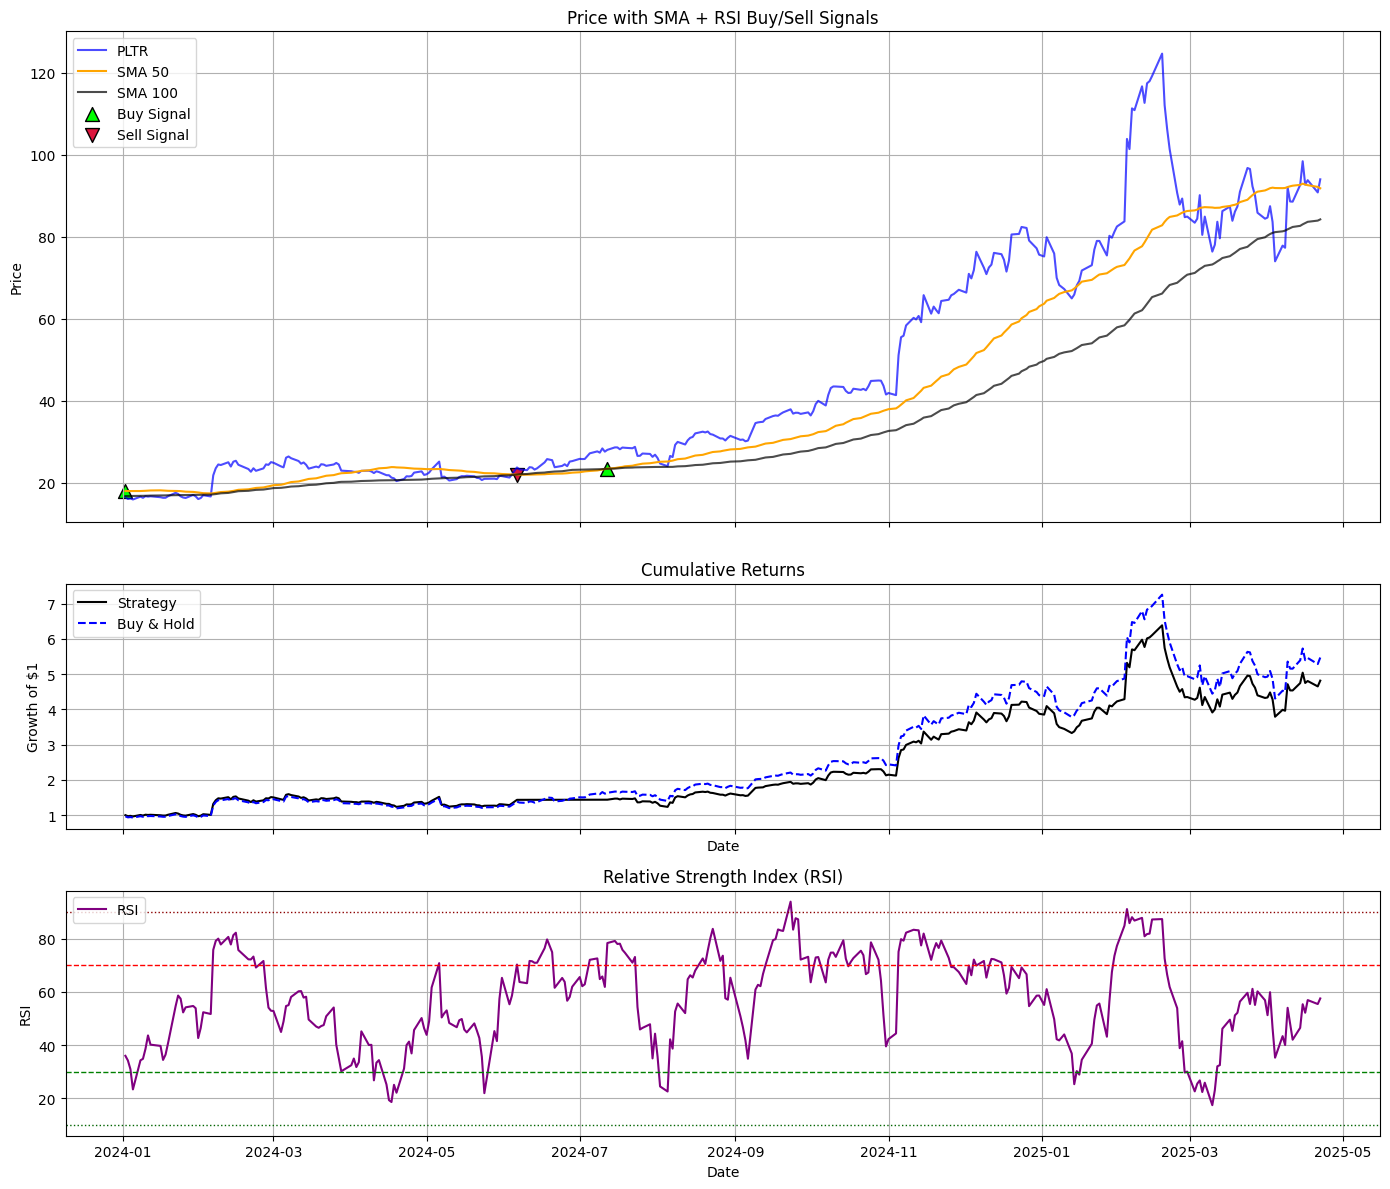

In [6]:
if __name__ == '__main__':
    ticker, shorting, start, end, ma1, ma2, cash = get_user_inputs()
    df, start_date = load_data(ticker, start, end, max(ma1, ma2))
    if df.empty:
        print(f"❌ Failed to load {ticker} from {start} to {end}")
    else:
        df = moving_average(df, ma1, ma2, cash, shorting, start_date)
        print_results(df, ticker, start, end)
        plot_strategy(df[df.index >= start_date], ticker, ma1, ma2)